In [1]:
!pip install optuna


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.4/383.4 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 6.7 MB/s eta 0:00:00


In [2]:
!pip install torch transformers peft datasets accelerate bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 97.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 95.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 37.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 MB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
!pip install transformers peft datasets accelerate bitsandbytes torch

In [4]:
import pandas as pd
file_path = "dataEquilibre.xlsx"
df = pd.read_excel(file_path)

In [5]:
import pandas as pd
import re
import spacy
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split
import torch
# Supprimer les doublons
df = df.drop_duplicates(subset=["description"], keep="first")
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

# Appliquer la fonction
df["description"] = df["description"].apply(clean_text)


In [6]:
label_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
df['label'] = df['label'].map(label_mapping)

In [7]:
print(df["label"].value_counts())

label
0    330
1    330
2    330
Name: count, dtype: int64


In [8]:
from datasets import Dataset
tokenizer = AutoTokenizer.from_pretrained("nickmuchi/deberta-v3-base-finetuned-finance-text-classification")

def preprocess_data(examples):
    return tokenizer(
        examples["description"],
        padding="max_length",
        truncation=True,
        max_length=128
    )

# Conversion en Dataset Hugging Face
dataset = Dataset.from_pandas(df)
dataset = dataset.map(preprocess_data, batched=True)
dataset = dataset.remove_columns(["description"])
dataset = dataset.rename_column("label", "labels")
dataset.set_format("torch")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/368 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/8.66M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/18.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

Map:   0%|          | 0/990 [00:00<?, ? examples/s]

In [10]:
from peft import LoraConfig, get_peft_model
from transformers import AutoModelForSequenceClassification

model_id = "nickmuchi/deberta-v3-base-finetuned-finance-text-classification"
model = AutoModelForSequenceClassification.from_pretrained(model_id, num_labels=3)


lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    lora_dropout=0.1,
    bias="none",
    task_type="SEQ_CLS"
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()


config.json:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/738M [00:00<?, ?B/s]

trainable params: 297,219 || all params: 184,721,670 || trainable%: 0.1609


In [12]:
from transformers import TrainingArguments, Trainer

split = dataset.train_test_split(test_size=0.3)
train_dataset = split["train"]
test_dataset = split["test"]


In [14]:
import optuna
from transformers import TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def objective(trial):
    # Hyperparamètres à optimiser
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 5e-4)
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32])
    num_train_epochs = trial.suggest_int("num_train_epochs", 3, 20)
    lora_alpha = trial.suggest_int("lora_alpha", 8, 64)
    lora_dropout = trial.suggest_uniform("lora_dropout", 0.0, 0.3)

    # Mise à jour de la config LoRa
    lora_config.lora_alpha = lora_alpha
    lora_config.lora_dropout = lora_dropout

    model = get_peft_model(
        AutoModelForSequenceClassification.from_pretrained(
            "nickmuchi/deberta-v3-base-finetuned-finance-text-classification",
            num_labels=3
        ),
        lora_config
    )

    training_args = TrainingArguments(
        output_dir="./optuna_results",
        evaluation_strategy="epoch",
        save_strategy="no",
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=num_train_epochs,
        learning_rate=learning_rate,
        weight_decay=0.01,
        logging_dir="./logs",
        logging_steps=50,
        report_to="none"
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        tokenizer=tokenizer,
    )

    trainer.train()

    # Évaluation
    predictions = trainer.predict(test_dataset)
    preds = predictions.predictions.argmax(-1)
    labels = test_dataset["labels"]
    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="macro")

    # Optuna va chercher à maximiser la métrique retournée
    return f1

# Création de l'étude Optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

# Meilleurs hyperparamètres trouvés
print("Meilleurs hyperparamètres : ", study.best_params)


[I 2025-02-10 08:47:15,921] A new study created in memory with name: no-name-31b49b97-9ebe-4436-9ea3-64c7cc9844f6
<ipython-input-14-ffe28781ee3b>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 5e-4)
<ipython-input-14-ffe28781ee3b>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  lora_dropout = trial.suggest_uniform("lora_dropout", 0.0, 0.3)
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-14-ffe28781ee3b>:43: FutureWarning: `tokeniz

Epoch,Training Loss,Validation Loss
1,No log,0.313482
2,0.483200,0.295295
3,0.436500,0.285440
4,0.368800,0.278764
5,0.280800,0.273487
6,0.269900,0.268073
7,0.255900,0.264065
8,0.250900,0.260233
9,0.250900,0.258963


[I 2025-02-10 08:49:58,433] Trial 0 finished with value: 0.910365378328765 and parameters: {'learning_rate': 1.1870847986372496e-05, 'batch_size': 16, 'num_train_epochs': 9, 'lora_alpha': 54, 'lora_dropout': 0.11250735825716388}. Best is trial 0 with value: 0.910365378328765.
<ipython-input-14-ffe28781ee3b>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 5e-4)
<ipython-input-14-ffe28781ee3b>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  lora_dropout = trial.suggest_uniform("lora_dropout", 0.0, 0.3)
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is depreca

Epoch,Training Loss,Validation Loss
1,0.454300,0.218022
2,0.237600,0.187483
3,0.090500,0.188730
4,0.156600,0.191237
5,0.127000,0.203312
6,0.082800,0.194553
7,0.103500,0.195240
8,0.070200,0.212734
9,0.130500,0.190055
10,0.104200,0.190634


[I 2025-02-10 08:55:49,830] Trial 1 finished with value: 0.9565671336624927 and parameters: {'learning_rate': 0.00014711955054605194, 'batch_size': 8, 'num_train_epochs': 18, 'lora_alpha': 12, 'lora_dropout': 0.1074020926261752}. Best is trial 1 with value: 0.9565671336624927.
<ipython-input-14-ffe28781ee3b>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 5e-4)
<ipython-input-14-ffe28781ee3b>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  lora_dropout = trial.suggest_uniform("lora_dropout", 0.0, 0.3)
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprec

Epoch,Training Loss,Validation Loss
1,0.391800,0.203707
2,0.192600,0.189226
3,0.082400,0.190277
4,0.143600,0.188947
5,0.103300,0.191293
6,0.058500,0.181710
7,0.069100,0.194722
8,0.072900,0.187472
9,0.107300,0.184084
10,0.100500,0.184959


[I 2025-02-10 08:59:18,568] Trial 2 finished with value: 0.9632011888364072 and parameters: {'learning_rate': 0.00010063066121324345, 'batch_size': 8, 'num_train_epochs': 11, 'lora_alpha': 46, 'lora_dropout': 0.03084674813190866}. Best is trial 2 with value: 0.9632011888364072.
<ipython-input-14-ffe28781ee3b>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 5e-4)
<ipython-input-14-ffe28781ee3b>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  lora_dropout = trial.suggest_uniform("lora_dropout", 0.0, 0.3)
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is depre

Epoch,Training Loss,Validation Loss
1,0.245000,0.239202
2,0.143200,0.196600
3,0.099600,0.191731
4,0.124300,0.180050
5,0.065500,0.206282
6,0.024000,0.182667
7,0.061500,0.181786
8,0.025100,0.205373
9,0.025100,0.184125
10,0.044800,0.183873


[I 2025-02-10 09:02:26,967] Trial 3 finished with value: 0.9602350911874722 and parameters: {'learning_rate': 0.00048510819878782587, 'batch_size': 8, 'num_train_epochs': 10, 'lora_alpha': 40, 'lora_dropout': 0.21765288804661237}. Best is trial 2 with value: 0.9632011888364072.
<ipython-input-14-ffe28781ee3b>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 5e-4)
<ipython-input-14-ffe28781ee3b>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  lora_dropout = trial.suggest_uniform("lora_dropout", 0.0, 0.3)
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is depre

Epoch,Training Loss,Validation Loss
1,No log,0.289581
2,0.392500,0.237768
3,0.289100,0.211247
4,0.215500,0.198716
5,0.164000,0.192600
6,0.119400,0.184953
7,0.133500,0.184295
8,0.103300,0.181952
9,0.103300,0.180154
10,0.126000,0.179066


[I 2025-02-10 09:07:32,942] Trial 4 finished with value: 0.9633703950291385 and parameters: {'learning_rate': 4.489352544691408e-05, 'batch_size': 16, 'num_train_epochs': 17, 'lora_alpha': 41, 'lora_dropout': 0.2248793959438359}. Best is trial 4 with value: 0.9633703950291385.
<ipython-input-14-ffe28781ee3b>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 5e-4)
<ipython-input-14-ffe28781ee3b>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  lora_dropout = trial.suggest_uniform("lora_dropout", 0.0, 0.3)
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprec

Epoch,Training Loss,Validation Loss
1,No log,0.336967
2,No log,0.318782
3,0.530400,0.309049
4,0.530400,0.304303
5,0.422600,0.302910


[I 2025-02-10 09:09:01,866] Trial 5 finished with value: 0.8972635772287593 and parameters: {'learning_rate': 1.9095236074402932e-05, 'batch_size': 32, 'num_train_epochs': 5, 'lora_alpha': 24, 'lora_dropout': 0.07146005278206914}. Best is trial 4 with value: 0.9633703950291385.
<ipython-input-14-ffe28781ee3b>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 5e-4)
<ipython-input-14-ffe28781ee3b>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  lora_dropout = trial.suggest_uniform("lora_dropout", 0.0, 0.3)
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is depre

Epoch,Training Loss,Validation Loss
1,0.638700,0.323026
2,0.441100,0.302073
3,0.336500,0.299377
4,0.371300,0.295101
5,0.296300,0.289067
6,0.311400,0.288171
7,0.293600,0.288505


[I 2025-02-10 09:11:16,432] Trial 6 finished with value: 0.8902608003731599 and parameters: {'learning_rate': 1.8818286747358583e-05, 'batch_size': 8, 'num_train_epochs': 7, 'lora_alpha': 8, 'lora_dropout': 0.09043103659163859}. Best is trial 4 with value: 0.9633703950291385.
<ipython-input-14-ffe28781ee3b>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 5e-4)
<ipython-input-14-ffe28781ee3b>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  lora_dropout = trial.suggest_uniform("lora_dropout", 0.0, 0.3)
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is depreca

Epoch,Training Loss,Validation Loss
1,0.623900,0.312326
2,0.411800,0.297053
3,0.292800,0.296098
4,0.345200,0.284599
5,0.270900,0.273445
6,0.266600,0.269368
7,0.247300,0.267213
8,0.253800,0.263415
9,0.267400,0.262266


[I 2025-02-10 09:14:06,587] Trial 7 finished with value: 0.9141034608321611 and parameters: {'learning_rate': 1.632464338892016e-05, 'batch_size': 8, 'num_train_epochs': 9, 'lora_alpha': 15, 'lora_dropout': 0.09963394853638924}. Best is trial 4 with value: 0.9633703950291385.
<ipython-input-14-ffe28781ee3b>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 5e-4)
<ipython-input-14-ffe28781ee3b>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  lora_dropout = trial.suggest_uniform("lora_dropout", 0.0, 0.3)
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is depreca

Epoch,Training Loss,Validation Loss
1,0.444100,0.218790
2,0.222900,0.194014
3,0.089500,0.192260
4,0.154900,0.195028
5,0.133500,0.208700
6,0.081600,0.203322
7,0.101600,0.200703
8,0.071700,0.207076
9,0.125200,0.198196
10,0.102200,0.199749


[I 2025-02-10 09:20:18,191] Trial 8 finished with value: 0.9565671336624927 and parameters: {'learning_rate': 6.430011490165062e-05, 'batch_size': 8, 'num_train_epochs': 20, 'lora_alpha': 45, 'lora_dropout': 0.015466089311625197}. Best is trial 4 with value: 0.9633703950291385.
<ipython-input-14-ffe28781ee3b>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 5e-4)
<ipython-input-14-ffe28781ee3b>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  lora_dropout = trial.suggest_uniform("lora_dropout", 0.0, 0.3)
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is depre

Epoch,Training Loss,Validation Loss
1,0.650600,0.337108
2,0.485200,0.313244
3,0.387000,0.303260
4,0.414800,0.298665
5,0.317000,0.292676
6,0.329200,0.292111
7,0.298600,0.290702
8,0.305600,0.285424
9,0.300800,0.279558
10,0.313700,0.273667


[I 2025-02-10 09:25:35,491] Trial 9 finished with value: 0.910365378328765 and parameters: {'learning_rate': 1.1696075886969097e-05, 'batch_size': 8, 'num_train_epochs': 17, 'lora_alpha': 8, 'lora_dropout': 0.14207580900355882}. Best is trial 4 with value: 0.9633703950291385.


Meilleurs hyperparamètres :  {'learning_rate': 4.489352544691408e-05, 'batch_size': 16, 'num_train_epochs': 17, 'lora_alpha': 41, 'lora_dropout': 0.2248793959438359}


In [15]:
from peft import LoraConfig, get_peft_model
from transformers import AutoModelForSequenceClassification

model_id = "nickmuchi/deberta-v3-base-finetuned-finance-text-classification"
model = AutoModelForSequenceClassification.from_pretrained(model_id, num_labels=3)

lora_config = LoraConfig(
    r=8,
    lora_alpha=41,
    lora_dropout=0.2248,
    bias="none",
    task_type="SEQ_CLS"
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()


trainable params: 297,219 || all params: 184,721,670 || trainable%: 0.1609


In [28]:
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback
from sklearn.metrics import accuracy_score
import numpy as np

# Définir la fonction pour calculer les métriques
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    accuracy = accuracy_score(labels, preds)
    return {"accuracy": accuracy}

split = dataset.train_test_split(test_size=0.2)
train_dataset = split["train"]
test_dataset = split["test"]

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=4.489352544691408e-05,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=50,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    push_to_hub=False,
    report_to="none",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

early_stopping = EarlyStoppingCallback(early_stopping_patience=5)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping]
)

# Entraînement
trainer.train()


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-28-f4ef526884bd>:35: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.113800,0.153044,0.974747
2,0.052400,0.182864,0.969697
3,0.004200,0.155122,0.974747
4,0.031000,0.174913,0.974747
5,0.084500,0.169255,0.969697
6,0.074400,0.162103,0.969697


TrainOutput(global_step=300, training_loss=0.046174785525848465, metrics={'train_runtime': 115.7758, 'train_samples_per_second': 342.04, 'train_steps_per_second': 21.593, 'total_flos': 313669057388544.0, 'train_loss': 0.046174785525848465, 'epoch': 6.0})

In [29]:
from sklearn.metrics import accuracy_score

# Prédictions sur le dataset de test
predictions = trainer.predict(test_dataset)
preds = predictions.predictions.argmax(-1)

# Calculer l'accuracy
accuracy = accuracy_score(test_dataset["labels"], preds)
print(f"Accuracy : {accuracy:.4f}")


Accuracy : 0.9747


In [30]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Obtenir les prédictions du modèle
predictions = trainer.predict(test_dataset)
preds = predictions.predictions.argmax(-1)

# Extraire les vraies étiquettes
true_labels = test_dataset["labels"]

accuracy = accuracy_score(true_labels, preds)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, preds, average="macro")
report = classification_report(true_labels, preds, target_names=["Negative", "Neutral", "Positive"])

# Affichage des résultats
print(f"Accuracy  : {accuracy:.4f}")
print(f"Precision : {precision:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"F1-score  : {f1:.4f}\n")

print("📊 Rapport de Classification :\n", report)


Accuracy  : 0.9747
Precision : 0.9736
Recall    : 0.9736
F1-score  : 0.9736

📊 Rapport de Classification :
               precision    recall  f1-score   support

    Negative       0.99      0.99      0.99        74
     Neutral       0.96      0.96      0.96        54
    Positive       0.97      0.97      0.97        70

    accuracy                           0.97       198
   macro avg       0.97      0.97      0.97       198
weighted avg       0.97      0.97      0.97       198



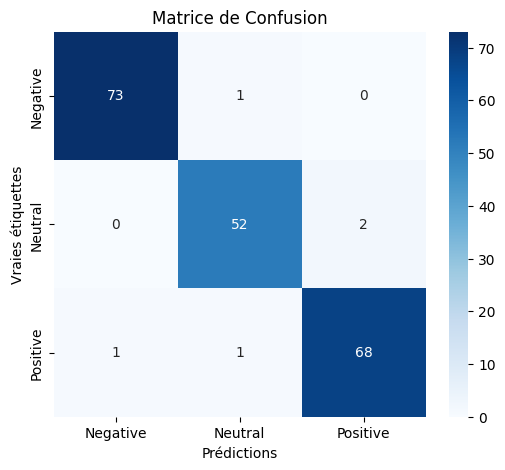

In [31]:
conf_matrix = confusion_matrix(true_labels, preds)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Neutral", "Positive"], yticklabels=["Negative", "Neutral", "Positive"])
plt.xlabel("Prédictions")
plt.ylabel("Vraies étiquettes")
plt.title("Matrice de Confusion")
plt.show()

In [21]:
model.save_pretrained("./deberta_lora_finetuned")
tokenizer.save_pretrained("./deberta_lora_finetuned")


('./deberta_lora_finetuned/tokenizer_config.json',
 './deberta_lora_finetuned/special_tokens_map.json',
 './deberta_lora_finetuned/spm.model',
 './deberta_lora_finetuned/added_tokens.json',
 './deberta_lora_finetuned/tokenizer.json')

In [32]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [33]:
# Enregistrer le modèle et le tokenizer sur Google Drive
model.save_pretrained("/content/drive/MyDrive/deberta_lora_finetuned")
tokenizer.save_pretrained("/content/drive/MyDrive/deberta_lora_finetuned")


('/content/drive/MyDrive/deberta_lora_finetuned/tokenizer_config.json',
 '/content/drive/MyDrive/deberta_lora_finetuned/special_tokens_map.json',
 '/content/drive/MyDrive/deberta_lora_finetuned/spm.model',
 '/content/drive/MyDrive/deberta_lora_finetuned/added_tokens.json',
 '/content/drive/MyDrive/deberta_lora_finetuned/tokenizer.json')